In [1]:
dataset_path = '/home/hindupur.v/varsha_hpp/dataset/data'

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import pandas as pd

In [3]:
data_dir = '/home/hindupur.v/varsha_hpp/dataset/data'

# Preparing DataFrame
filepaths = []
labels = []
label_dict = {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}  # Assuming these are the only folders for lung dataset

for folder in ['lung_aca', 'lung_n', 'lung_scc']:  # Loop only through lung related folders
    folder_path = os.path.join(data_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg'):  # Filter only jpeg images
            filepaths.append(os.path.join(folder_path, filename))
            labels.append(label_dict[folder])

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

In [4]:
df.shape

(15000, 2)

In [5]:
# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [6]:
class LungDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
train_dataset = LungDataset(dataframe=train_df, transform=transform)
valid_dataset = LungDataset(dataframe=valid_df, transform=transform)
test_dataset = LungDataset(dataframe=test_df, transform=transform)

In [15]:
num_cpu_cores = 12
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_cpu_cores)  # Use 8 worker processes
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=num_cpu_cores)  # Use 8 worker processes
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_cpu_cores)  # Use 8 worker processes

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/hindupur.v/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 3)  # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Adjust shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
class CustomCNN(nn.Module):
    # CNN1_LungColon architecture but adjusted for N classes
    num_classes = 3
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, num_classes)  # Adjust for N classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
num_classes = 3
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # labels are expected to be class indices
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    valid_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data).item()

    valid_acc = correct / len(valid_loader.dataset)
    print(f'Epoch {epoch+1}, Valid Acc: {valid_acc}')

Epoch 1, Valid Acc: 0.9213333333333333
Epoch 2, Valid Acc: 0.9256666666666666
Epoch 3, Valid Acc: 0.86
Epoch 4, Valid Acc: 0.931
Epoch 5, Valid Acc: 0.9263333333333333
Epoch 6, Valid Acc: 0.9186666666666666
Epoch 7, Valid Acc: 0.928
Epoch 8, Valid Acc: 0.931
Epoch 9, Valid Acc: 0.9293333333333333
Epoch 10, Valid Acc: 0.9346666666666666


In [18]:
# Save model state dictionaries
torch.save(model.state_dict(), 'model_lung_cnn.pth')

In [19]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Evaluate model1 on the test set
evaluate_model(model, test_loader, criterion)

Test Loss: 0.5025, Test Accuracy: 0.9250


In [21]:
train_losses = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

Epoch 1, Train Loss: 0.0009, Valid Loss: 0.4166, Valid Acc: 0.9343
Epoch 2, Train Loss: 0.0004, Valid Loss: 0.4447, Valid Acc: 0.9330
Epoch 3, Train Loss: 0.0003, Valid Loss: 0.4742, Valid Acc: 0.9317
Epoch 4, Train Loss: 0.0002, Valid Loss: 0.4917, Valid Acc: 0.9313
Epoch 5, Train Loss: 0.0001, Valid Loss: 0.5068, Valid Acc: 0.9307
Epoch 6, Train Loss: 0.0001, Valid Loss: 0.5181, Valid Acc: 0.9310
Epoch 7, Train Loss: 0.0001, Valid Loss: 0.5356, Valid Acc: 0.9310
Epoch 8, Train Loss: 0.0001, Valid Loss: 0.5486, Valid Acc: 0.9307
Epoch 9, Train Loss: 0.0001, Valid Loss: 0.5529, Valid Acc: 0.9320
Epoch 10, Train Loss: 0.0000, Valid Loss: 0.5650, Valid Acc: 0.9320


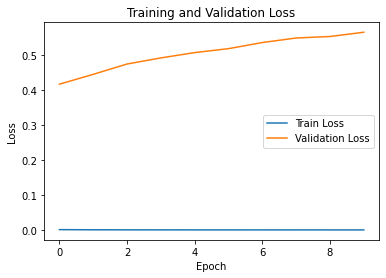

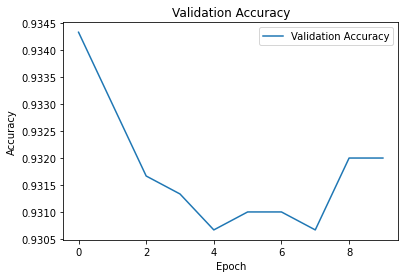

In [22]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

plot_learning_curves(train_losses, valid_losses, valid_accuracies)